<a href="https://colab.research.google.com/github/ocjorge/CarDetection/blob/main/CarDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# PASO -1: MONTAR GOOGLE DRIVE
# ==============================================================================
print("Paso -1: Montando Google Drive...")
from google.colab import drive
drive.mount('/content/drive')

Paso -1: Montando Google Drive...
Mounted at /content/drive


In [ ]:
# ==============================================================================
# PASO 0: INSTALACIÓN DE LIBRERÍAS NECESARIAS
# ==============================================================================
print("\nPaso 0: Instalando librerías...")
!pip install ultralytics -q
!pip install pyyaml -q

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import zipfile
from ultralytics import YOLO
import ultralytics
from google.colab import files

print("Librerías instaladas y módulos importados.")
print(f"Ultralytics versión: {ultralytics.__version__}")


Paso 0: Instalando librerías...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settin

In [ ]:
# ==============================================================================
# PASO 0.5: CONFIGURACIÓN DE RUTAS DE DRIVE Y DESCOMPRESIÓN DEL DATASET (TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 0.5: Configurando rutas de Drive y descomprimiendo TU dataset de vehículos...")

# --------- MODIFICA ESTAS VARIABLES SI ES NECESARIO ---------
# Ruta en tu Google Drive donde está el archivo ZIP de tu dataset DE VEHÍCULOS
DRIVE_DATASET_ZIP_PATH = "/content/vehicle_dataset.zip"  # <<<<<<< CAMBIA ESTO a la ruta de tu ZIP de VEHÍCULOS

COLAB_BASE_PATH = "/content/"
EXTRACT_DIR_NAME = "vehicle_dataset_extracted"
EXTRACT_TO_DIR = os.path.join(COLAB_BASE_PATH, EXTRACT_DIR_NAME)

# Nombre de la carpeta principal DENTRO del ZIP que contiene 'train', 'valid', etc.
EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP = "vehicle dataset" # <<<<<<< AJUSTA ESTO según la estructura de tu ZIP de VEHÍCULOS
# -----------------------------------------------------------

DRIVE_WORKING_DIR_BASE = "/content/drive/MyDrive/YOLO_FineTuning_Results"
os.makedirs(DRIVE_WORKING_DIR_BASE, exist_ok=True)
COLAB_WORKING_DIR = os.path.join(COLAB_BASE_PATH, "yolo_finetune_output")

if os.path.exists(DRIVE_DATASET_ZIP_PATH):
    print(f"Archivo ZIP encontrado en Drive: {DRIVE_DATASET_ZIP_PATH}")
    print(f"Extrayendo a: {EXTRACT_TO_DIR}...")
    os.makedirs(EXTRACT_TO_DIR, exist_ok=True)
    !unzip -q -o "{DRIVE_DATASET_ZIP_PATH}" -d "{EXTRACT_TO_DIR}"
    print("Descompresión completada.")

    if EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP:
        BASE_DATASET_PATH = os.path.join(EXTRACT_TO_DIR, EXPECTED_TOP_LEVEL_FOLDER_INSIDE_ZIP)
    else:
        BASE_DATASET_PATH = EXTRACT_TO_DIR

    print(f"El dataset base (vehículos) ahora está en: {BASE_DATASET_PATH}")
    if not os.path.exists(BASE_DATASET_PATH):
        raise FileNotFoundError(f"Dataset de vehículos no encontrado en {BASE_DATASET_PATH} después de la extracción.")
else:
    raise FileNotFoundError(f"Archivo ZIP de vehículos {DRIVE_DATASET_ZIP_PATH} no encontrado en Google Drive.")



Paso 0.5: Configurando rutas de Drive y descomprimiendo TU dataset de vehículos...
Archivo ZIP encontrado en Drive: /content/vehicle_dataset.zip
Extrayendo a: /content/vehicle_dataset_extracted...
Descompresión completada.
El dataset base (vehículos) ahora está en: /content/vehicle_dataset_extracted/vehicle dataset


In [ ]:
# ==============================================================================
# PASO 1: DEFINICIÓN DE RUTAS Y VARIABLES PRINCIPALES (PARA EL DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 1: Definiendo rutas y variables...")

TRAIN_DIR = os.path.join(BASE_DATASET_PATH, 'train')
VALID_DIR = os.path.join(BASE_DATASET_PATH, 'valid')

# ----- CLASES EN TU DATASET DE VEHÍCULOS (para el data.yaml y entrenamiento) -----
# Estas son las clases que tu dataset de vehículos contiene y que el modelo aprenderá/refinará.
CLASSES_IN_VEHICLE_DATASET = ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van'] # <<<< AJUSTA ESTO EXACTAMENTE a tu dataset
NUM_CLASSES_VEHICLE_DATASET = len(CLASSES_IN_VEHICLE_DATASET)
# ------------------------------------------------------------------------------------

# ----- CLASES QUE ESPERAMOS DETECTAR EN INFERENCIA (incluye las de COCO) -----
# El modelo base yolov8n.pt conoce las clases de COCO.
# Después del fine-tuning, el modelo debería reconocer tus vehículos Y las clases de COCO.
# "pothole" NO está en COCO. Si quieres "pothole", NECESITAS añadir datos para ello.
CLASSES_FOR_INFERENCE = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'dog', # Comunes de COCO
                         'threewheel', 'van'] # Específicas de tu dataset
# NOTA: 'pothole' se omite aquí porque no tenemos datos para ello.
# Si TUVIERAS un dataset de potholes y lo incluyeras en el entrenamiento, lo añadirías aquí.
# ------------------------------------------------------------------------------------


os.makedirs(COLAB_WORKING_DIR, exist_ok=True)
DATA_YAML_PATH = os.path.join(COLAB_WORKING_DIR, 'vehicle_data.yaml') # YAML para tu dataset de vehículos

print(f"Directorio de entrenamiento (vehículos): {TRAIN_DIR}")
print(f"Directorio de validación (vehículos): {VALID_DIR}")
print(f"Clases en TU dataset de vehículos (para entrenamiento): {CLASSES_IN_VEHICLE_DATASET}")
print(f"Clases esperadas en inferencia (aprox): {CLASSES_FOR_INFERENCE}")
print(f"Archivo YAML se guardará en: {DATA_YAML_PATH}")
print(f"Los resultados del entrenamiento (runs) se guardarán temporalmente en: {COLAB_WORKING_DIR}/runs")

# Verificaciones de directorios
for d_path in [TRAIN_DIR, VALID_DIR]:
    if not os.path.exists(d_path) or \
       not os.path.exists(os.path.join(d_path, 'images')) or \
       not os.path.exists(os.path.join(d_path, 'labels')):
        print(f"ADVERTENCIA: El directorio {d_path} o sus subcarpetas 'images'/'labels' no existen o están mal configurados.")


Paso 1: Definiendo rutas y variables...
Directorio de entrenamiento (vehículos): /content/vehicle_dataset_extracted/vehicle dataset/train
Directorio de validación (vehículos): /content/vehicle_dataset_extracted/vehicle dataset/valid
Clases en TU dataset de vehículos (para entrenamiento): ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van']
Clases esperadas en inferencia (aprox): ['person', 'bicycle', 'car', 'motorbike', 'bus', 'truck', 'dog', 'threewheel', 'van']
Archivo YAML se guardará en: /content/yolo_finetune_output/vehicle_data.yaml
Los resultados del entrenamiento (runs) se guardarán temporalmente en: /content/yolo_finetune_output/runs



Paso 2: Exploración de datos (dataset de vehículos)...


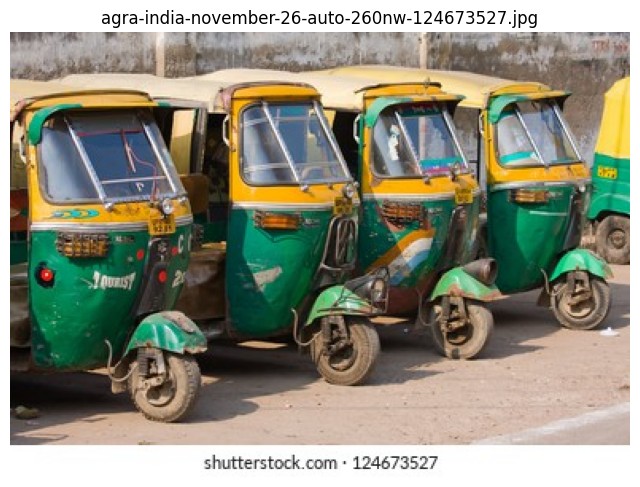


Contando etiquetas en el conjunto de entrenamiento de VEHÍCULOS (/content/vehicle_dataset_extracted/vehicle dataset/train/labels)...

Distribución de clases en el conjunto de entrenamiento (VEHÍCULOS):
car: 461
threewheel: 482
bus: 403
truck: 478
motorbike: 483
van: 378


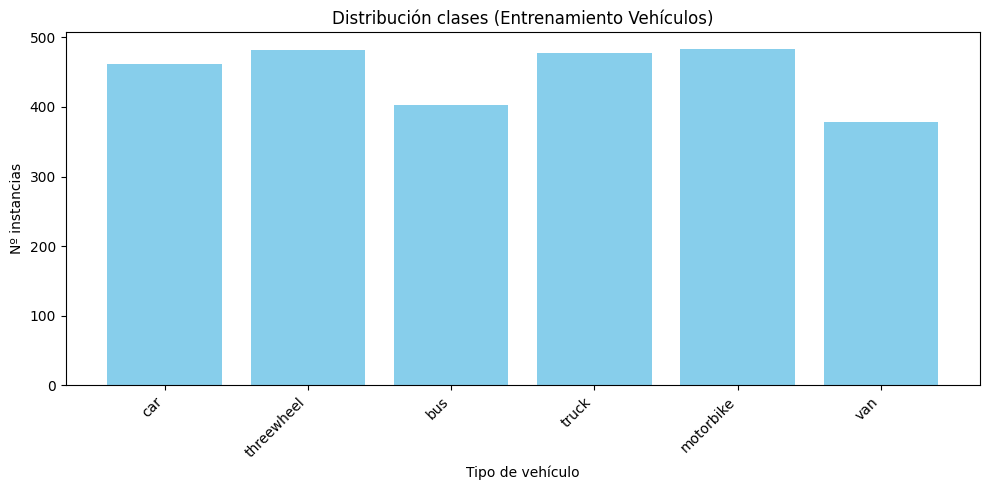

In [ ]:
# ==============================================================================
# PASO 2: EXPLORACIÓN DE DATOS (DE TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 2: Exploración de datos (dataset de vehículos)...")
def image_plot(file_path): # Misma función
    img = cv2.imread(file_path);
    if img is None: print(f"Error: No se pudo cargar la imagen {file_path}"); return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB); plt.figure(figsize=(8,8))
    plt.imshow(img_rgb); plt.title(os.path.basename(file_path)); plt.axis('off'); plt.show()
    return img_rgb

train_images_path = os.path.join(TRAIN_DIR, 'images')
try:
    sample_images_list = glob.glob(os.path.join(train_images_path, '*.jpg')) + glob.glob(os.path.join(train_images_path, '*.png'))
    if sample_images_list: image_plot(sample_images_list[0])
    else: print(f"No se encontraron imágenes en {train_images_path}")
except Exception as e: print(f"Error listando imágenes: {e}")

def count_labels_in_files(label_files_dir, num_classes, class_names_map): # Misma función
    counts = {name: 0 for name in class_names_map}
    if not os.path.exists(label_files_dir): print(f"Dir de etiquetas no encontrado: {label_files_dir}"); return counts
    label_files = glob.glob(os.path.join(label_files_dir, '*.txt'))
    if not label_files: print(f"No archivos .txt en {label_files_dir}"); return counts
    for file_path in label_files:
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.split();
                    if parts:
                        class_id = int(parts[0])
                        if 0 <= class_id < num_classes: counts[class_names_map[class_id]] += 1
                        else: print(f"ID clase fuera de rango ({class_id}) en: {file_path}")
        except Exception as e: print(f"Error procesando {file_path}: {e}")
    return counts

train_labels_dir = os.path.join(TRAIN_DIR, 'labels')
print(f"\nContando etiquetas en el conjunto de entrenamiento de VEHÍCULOS ({train_labels_dir})...")
label_counts_dict = count_labels_in_files(train_labels_dir, NUM_CLASSES_VEHICLE_DATASET, CLASSES_IN_VEHICLE_DATASET)

print("\nDistribución de clases en el conjunto de entrenamiento (VEHÍCULOS):")
for class_name, count in label_counts_dict.items(): print(f"{class_name}: {count}")
if sum(label_counts_dict.values()) > 0 :
    plt.figure(figsize=(10, 5)); plt.bar(label_counts_dict.keys(), label_counts_dict.values(), color='skyblue')
    plt.xlabel('Tipo de vehículo'); plt.ylabel('Nº instancias'); plt.title('Distribución clases (Entrenamiento Vehículos)')
    plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()
else: print("No se encontraron etiquetas para graficar.")

In [ ]:
# ==============================================================================
# PASO 3: CREACIÓN DEL ARCHIVO data.yaml (PARA TU DATASET DE VEHÍCULOS)
# ==============================================================================
print("\nPaso 3: Creando el archivo data.yaml para el dataset de vehículos...")
data_yaml_content = {
    'path': BASE_DATASET_PATH,
    'train': 'train/images',
    'val': 'valid/images',
    'nc': NUM_CLASSES_VEHICLE_DATASET,
    'names': CLASSES_IN_VEHICLE_DATASET # Solo las clases de tu dataset de vehículos
}
try:
    with open(DATA_YAML_PATH, 'w') as f: yaml.dump(data_yaml_content, f, sort_keys=False, Dumper=yaml.SafeDumper)
    print(f"Archivo data.yaml creado en {DATA_YAML_PATH}")
    with open(DATA_YAML_PATH, 'r') as f: print(f"\nContenido de data.yaml:\n{f.read()}")
except Exception as e: print(f"Error al crear data.yaml: {e}")



Paso 3: Creando el archivo data.yaml para el dataset de vehículos...
Archivo data.yaml creado en /content/yolo_finetune_output/vehicle_data.yaml

Contenido de data.yaml:
path: /content/vehicle_dataset_extracted/vehicle dataset
train: train/images
val: valid/images
nc: 6
names:
- car
- threewheel
- bus
- truck
- motorbike
- van



In [ ]:
# ==============================================================================
# PASO 4: FINE-TUNING DEL MODELO YOLOv8 CON TU DATASET DE VEHÍCULOS
# (Este paso crea el 'best.pt' que se especializa en tus vehículos)
# ==============================================================================
print("\nPaso 4: Fine-tuning del modelo YOLOv8n.pt con tu dataset de VEHÍCULOS...")

# Verificar que las variables globales reflejen SOLO las clases de vehículos
if 'CLASS_NAMES' not in globals() or 'person' in CLASS_NAMES: # Chequeo simple
    print("ADVERTENCIA: CLASS_NAMES parece contener clases adicionales además de vehículos.")
    print("Para este PASO 4 (crear el modelo especializado en vehículos), CLASS_NAMES y DATA_YAML_PATH")
    print("deberían referirse ÚNICAMENTE a tu dataset de vehículos.")
    # Si CLASS_NAMES fue modificada para un intento de dataset combinado, necesitarías revertirla
    # o asegurar que el DATA_YAML_PATH correcto (solo vehículos) se esté usando.
    # Por ejemplo:
    # CLASS_NAMES = ['car', 'threewheel', 'bus', 'truck', 'motorbike', 'van'] # Original
    # NUM_CLASSES = len(CLASS_NAMES)
    # DATA_YAML_PATH = os.path.join(COLAB_WORKING_DIR, 'vehicle_data.yaml') # YAML solo de vehículos

print(f"Clases que se usarán para este entrenamiento (deberían ser solo vehículos): {CLASS_NAMES if 'CLASS_NAMES' in globals() else 'NO DEFINIDA'}")
print(f"Número de clases: {NUM_CLASSES if 'NUM_CLASSES' in globals() else 'NO DEFINIDA'}")
print(f"Usando archivo YAML: {DATA_YAML_PATH if 'DATA_YAML_PATH' in globals() else 'NO DEFINIDA'}")


if 'DATA_YAML_PATH' not in globals() or not os.path.exists(DATA_YAML_PATH):
    print(f"ERROR CRÍTICO: DATA_YAML_PATH no está definido o el archivo '{DATA_YAML_PATH}' no existe.")
    print("Asegúrate de que el PASO 3 se haya ejecutado correctamente y haya creado este archivo YAML (solo con vehículos).")
    raise FileNotFoundError(f"Archivo YAML de datos (solo vehículos) no encontrado o no definido.")

print("\nRealizando chequeo de Ultralytics..."); ultralytics.checks()

# Empezar con un modelo pre-entrenado en COCO
model_to_finetune_vehicles_only = YOLO("yolov8n.pt")
print(f"\nModelo YOLO('yolov8n.pt') cargado como base para fine-tuning (solo vehículos).")

# Parámetros de Fine-tuning (puedes ajustarlos)
BATCH_SIZE_VEHICLES = 16
EPOCHS_VEHICLES = 30 # O las épocas que usaste para obtener tu buen best.pt
IMG_SIZE_VEHICLES = 640
PROJECT_NAME_VEHICLE_TRAIN = "finetune_vehicles_only" # Nombre de proyecto para este run
EXPERIMENT_NAME_VEHICLE_TRAIN = "exp_vehicles_on_coco_base_vX" # Puedes versionar (ej. _v2, _v3)

# Asegurarse que COLAB_WORKING_DIR esté definido
if 'COLAB_WORKING_DIR' not in globals():
    COLAB_WORKING_DIR = "/content/yolo_default_working_dir_vehicles"
    os.makedirs(COLAB_WORKING_DIR, exist_ok=True)
    print(f"ADVERTENCIA: COLAB_WORKING_DIR no estaba definido, usando default: {COLAB_WORKING_DIR}")

print(f"Iniciando fine-tuning con batch_size={BATCH_SIZE_VEHICLES}, epochs={EPOCHS_VEHICLES}, imgsz={IMG_SIZE_VEHICLES}")
print(f"Los resultados se guardarán en: {os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_VEHICLE_TRAIN, EXPERIMENT_NAME_VEHICLE_TRAIN)}")

# Reinicializar BEST_MODEL_PATH para que se establezca con el resultado de este entrenamiento
BEST_MODEL_PATH = None
LATEST_RUN_DIR = None

try:
    results_vehicle_train = model_to_finetune_vehicles_only.train(
        data=DATA_YAML_PATH, # DEBE apuntar al YAML con SOLO tus clases de vehículos
        batch=BATCH_SIZE_VEHICLES,
        epochs=EPOCHS_VEHICLES,
        imgsz=IMG_SIZE_VEHICLES,
        project=os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_VEHICLE_TRAIN),
        name=EXPERIMENT_NAME_VEHICLE_TRAIN,
        patience=10, # Paciencia para early stopping
        exist_ok=True # Sobrescribe si la carpeta del experimento ya existe
    )
    print("Fine-tuning (solo vehículos) completado.")

    LATEST_RUN_DIR = results_vehicle_train.save_dir
    print(f"Resultados del fine-tuning (solo vehículos) guardados en: {LATEST_RUN_DIR}")

    BEST_MODEL_PATH = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')

    if os.path.exists(BEST_MODEL_PATH):
        print(f"El modelo fine-tuned (solo vehículos) se guardó en: {BEST_MODEL_PATH}")
        print("Este BEST_MODEL_PATH se usará en los siguientes pasos para las detecciones de vehículos.")
    else:
        print(f"ERROR CRÍTICO: best.pt no encontrado en {os.path.join(LATEST_RUN_DIR, 'weights')} después del entrenamiento.")
        BEST_MODEL_PATH = None

except Exception as e_vehicle_train:
    print(f"Ocurrió un error durante el fine-tuning (solo vehículos): {e_vehicle_train}")
    import traceback
    traceback.print_exc()
    BEST_MODEL_PATH = None

print("\n--- Fin del PASO 4 (Fine-tuning Solo Vehículos) ---")
if BEST_MODEL_PATH:
    print(f"La variable BEST_MODEL_PATH está ahora establecida como: {BEST_MODEL_PATH}")
else:
    print("ADVERTENCIA: BEST_MODEL_PATH no se pudo establecer. El entrenamiento pudo haber fallado.")


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.1/112.6 GB disk)


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.9MB/s]



Modelo YOLO('yolov8n.pt') cargado como base para fine-tuning (solo vehículos).
Iniciando fine-tuning con batch_size=16, epochs=30, imgsz=640
Los resultados se guardarán en: /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_finetune_output/vehicle_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               


  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1230.4±768.3 MB/s, size: 62.0 KB)


train: Scanning /content/vehicle_dataset_extracted/vehicle dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [00:00<00:00, 2343.56it/s]


train: New cache created: /content/vehicle_dataset_extracted/vehicle dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1058.4±985.6 MB/s, size: 183.8 KB)


val: Scanning /content/vehicle_dataset_extracted/vehicle dataset/valid/labels... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<00:00, 990.26it/s]

val: /content/vehicle_dataset_extracted/vehicle dataset/valid/images/car55.jpg: corrupt JPEG restored and saved


val: New cache created: /content/vehicle_dataset_extracted/vehicle dataset/valid/labels.cache
Plotting labels to /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.15G     0.6336      2.154      1.145         20        640: 100%|██████████| 132/132 [00:47<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


                   all        900       1150      0.769      0.705      0.832      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.02G      0.666      1.433      1.153         15        640: 100%|██████████| 132/132 [00:44<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.10it/s]


                   all        900       1150      0.764      0.654      0.786      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.04G     0.7129        1.3      1.174         11        640: 100%|██████████| 132/132 [00:43<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.94it/s]


                   all        900       1150      0.706      0.706      0.736      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.06G     0.7007      1.193      1.176         11        640: 100%|██████████| 132/132 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.18it/s]


                   all        900       1150      0.915       0.78      0.895      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.07G     0.6637      1.062      1.145         11        640: 100%|██████████| 132/132 [00:42<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.70it/s]


                   all        900       1150      0.776      0.683      0.786      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.09G     0.6524     0.9426      1.137         15        640: 100%|██████████| 132/132 [00:43<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.98it/s]


                   all        900       1150      0.877      0.841      0.929      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       3.1G     0.6229     0.8941       1.12         11        640: 100%|██████████| 132/132 [00:42<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.20it/s]

                   all        900       1150      0.904      0.841      0.921      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.12G     0.6088     0.8567      1.107          7        640: 100%|██████████| 132/132 [00:43<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.72it/s]

                   all        900       1150      0.863      0.832      0.904      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.13G      0.589     0.7772      1.094         11        640: 100%|██████████| 132/132 [00:43<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]

                   all        900       1150      0.882      0.847      0.932      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.15G     0.5833      0.744       1.08         11        640: 100%|██████████| 132/132 [00:42<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.19it/s]

                   all        900       1150      0.873      0.844      0.931       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.17G     0.5708     0.7276       1.08          8        640: 100%|██████████| 132/132 [00:42<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.70it/s]


                   all        900       1150      0.915      0.875      0.947      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.19G     0.5576     0.6912      1.071         15        640: 100%|██████████| 132/132 [00:42<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.97it/s]

                   all        900       1150      0.942      0.892      0.959      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       3.2G     0.5373     0.6554      1.065         13        640: 100%|██████████| 132/132 [00:42<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.21it/s]


                   all        900       1150      0.908      0.887      0.955      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.22G     0.5427     0.6285      1.064         13        640: 100%|██████████| 132/132 [00:42<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.79it/s]

                   all        900       1150      0.939      0.881      0.954      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.24G       0.51     0.5998      1.043         14        640: 100%|██████████| 132/132 [00:42<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.09it/s]

                   all        900       1150      0.927      0.911      0.962      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.25G     0.5187     0.5859      1.048         12        640: 100%|██████████| 132/132 [00:42<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.17it/s]

                   all        900       1150       0.95      0.898      0.964      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.27G     0.4994     0.5528      1.045         10        640: 100%|██████████| 132/132 [00:43<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.69it/s]

                   all        900       1150      0.939      0.914      0.966      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.29G     0.4826     0.5505      1.032         17        640: 100%|██████████| 132/132 [00:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.15it/s]

                   all        900       1150      0.957      0.907      0.968      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       3.3G     0.4807     0.5186      1.029         11        640: 100%|██████████| 132/132 [00:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]

                   all        900       1150      0.946      0.928      0.972      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.32G      0.475     0.5067      1.023         14        640: 100%|██████████| 132/132 [00:42<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.75it/s]

                   all        900       1150      0.956      0.913      0.971      0.882


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.34G     0.3777     0.4126     0.9593          4        640: 100%|██████████| 132/132 [00:42<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.16it/s]

                   all        900       1150      0.937      0.931      0.967      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.36G     0.3725     0.3778     0.9494          4        640: 100%|██████████| 132/132 [00:40<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.76it/s]

                   all        900       1150      0.948       0.93      0.973      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.37G     0.3545     0.3593     0.9335          5        640: 100%|██████████| 132/132 [00:40<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.99it/s]

                   all        900       1150      0.962      0.925      0.975      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.39G     0.3393     0.3364     0.9286          4        640: 100%|██████████| 132/132 [00:40<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.49it/s]


                   all        900       1150      0.964      0.934      0.977      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.41G     0.3268     0.3172     0.9192          7        640: 100%|██████████| 132/132 [00:39<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]

                   all        900       1150      0.956      0.936      0.976      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.42G     0.3091     0.2979     0.9106          4        640: 100%|██████████| 132/132 [00:40<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.66it/s]

                   all        900       1150      0.953      0.935      0.976      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.44G      0.302      0.292     0.9008          4        640: 100%|██████████| 132/132 [00:40<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.13it/s]

                   all        900       1150      0.966      0.933      0.979      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.46G     0.2921     0.2732     0.8957          4        640: 100%|██████████| 132/132 [00:40<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.85it/s]

                   all        900       1150      0.969       0.94      0.979      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.47G     0.2875     0.2709     0.8972          5        640: 100%|██████████| 132/132 [00:40<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.11it/s]

                   all        900       1150      0.964       0.95      0.981      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.49G     0.2736     0.2526     0.8831          6        640: 100%|██████████| 132/132 [00:41<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.86it/s]

                   all        900       1150      0.965       0.95       0.98      0.911



30 epochs completed in 0.430 hours.
Optimizer stripped from /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX/weights/last.pt, 6.2MB
Optimizer stripped from /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX/weights/best.pt, 6.2MB

Validating /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


                   all        900       1150      0.965       0.95       0.98      0.911
                   car        182        201      0.939      0.925       0.97      0.937
            threewheel        167        227      0.995      0.955      0.989      0.912
                   bus        162        185      0.977      0.984       0.99      0.957
                 truck        123        151      0.954       0.98      0.986      0.924
             motorbike        165        216       0.97      0.903      0.957      0.769
                   van        157        170      0.953      0.953      0.987      0.966
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX
Fine-tuning (solo vehículos) completado.
Resultados del fine-tuning (solo vehículos) guardados en: /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX
El mo


Paso 5: Evaluación e inferencia con el modelo fine-tuned...
Usando el modelo fine-tuned: /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX/weights/best.pt
Clases conocidas por el modelo fine-tuned (trained_model.names): {0: 'car', 1: 'threewheel', 2: 'bus', 3: 'truck', 4: 'motorbike', 5: 'van'}

Evaluando el modelo en el conjunto de validación (de vehículos)...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1990.3±570.1 MB/s, size: 113.7 KB)


val: Scanning /content/vehicle_dataset_extracted/vehicle dataset/valid/labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

val: /content/vehicle_dataset_extracted/vehicle dataset/valid/images/car55.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


                   all        900       1150      0.963       0.95       0.98      0.911
                   car        182        201      0.938      0.925       0.97      0.937
            threewheel        167        227      0.995      0.955       0.99      0.911
                   bus        162        185      0.975      0.984       0.99      0.957
                 truck        123        151       0.95       0.98      0.986      0.923
             motorbike        165        216      0.965      0.903      0.957      0.771
                   van        157        170      0.955      0.953      0.987      0.965
Speed: 0.4ms preprocess, 4.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
Métricas de validación (mAP50 para clases de vehículos): 0.979966011823969

Realizando inferencia. El modelo debería detectar tus vehículos y clases de COCO.
ADVERTENCIA: 'pothole' NO será detectado ya que no estaba en COCO ni en tu dataset de vehículos.
Usando 

<ipython-input-8-1b0f346ef629>:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(trained_model.names))


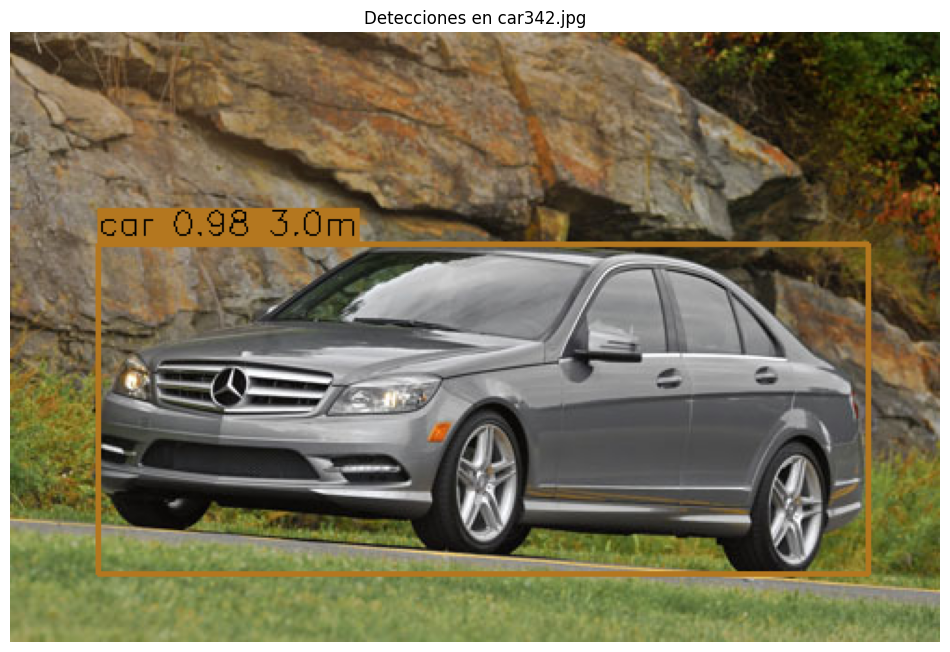

In [ ]:
# ==============================================================================
# PASO 5: EVALUACIÓN E INFERENCIA CON EL MODELO FINE-TUNED
# ==============================================================================
print("\nPaso 5: Evaluación e inferencia con el modelo fine-tuned...")

BEST_MODEL_PATH = None # Iniciar BEST_MODEL_PATH
if 'BEST_MODEL_PATH_TRAIN' in locals() and BEST_MODEL_PATH_TRAIN and os.path.exists(BEST_MODEL_PATH_TRAIN):
    BEST_MODEL_PATH = BEST_MODEL_PATH_TRAIN
# ... (lógica para encontrar BEST_MODEL_PATH si no está en BEST_MODEL_PATH_TRAIN, como en tu script original)
elif 'LATEST_RUN_DIR' in locals() and LATEST_RUN_DIR and os.path.exists(os.path.join(LATEST_RUN_DIR, 'weights/best.pt')):
     BEST_MODEL_PATH = os.path.join(LATEST_RUN_DIR, 'weights/best.pt')
else:
    search_pattern = os.path.join(COLAB_WORKING_DIR, 'runs', PROJECT_NAME_TRAIN, EXPERIMENT_NAME_TRAIN + '*', 'weights/best.pt')
    model_files = glob.glob(search_pattern)
    if model_files:
        model_files.sort(key=lambda x: os.path.getmtime(os.path.dirname(os.path.dirname(x))))
        BEST_MODEL_PATH = model_files[-1]

if BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    print(f"Usando el modelo fine-tuned: {BEST_MODEL_PATH}")
    # Al cargar el modelo, automáticamente conoce las clases con las que fue entrenado
    # (las de COCO originalmente + las que se refinaron/aprendieron de tu dataset)
    trained_model = YOLO(BEST_MODEL_PATH)

    # Los nombres de clase en trained_model.names ahora incluirán
    # una combinación de las clases de COCO y las clases de tu dataset.
    # Es importante verificar esto si hay solapamientos (ej. 'car').
    print(f"Clases conocidas por el modelo fine-tuned (trained_model.names): {trained_model.names}")


    print("\nEvaluando el modelo en el conjunto de validación (de vehículos)...")
    try:
        # La validación se hará con el data.yaml de vehículos,
        # por lo que las métricas serán para esas clases específicas.
        metrics = trained_model.val(data=DATA_YAML_PATH)
        if metrics and hasattr(metrics, 'box') and hasattr(metrics.box, 'map50'):
             print("Métricas de validación (mAP50 para clases de vehículos):", metrics.box.map50)
    except Exception as e: print(f"Error durante la validación: {e}")

    print("\nRealizando inferencia. El modelo debería detectar tus vehículos y clases de COCO.")
    print("ADVERTENCIA: 'pothole' NO será detectado ya que no estaba en COCO ni en tu dataset de vehículos.")

    FOCAL_LENGTH_PX = 700
    REAL_OBJECT_SIZES_M = {
        'car': 1.8, 'person': 0.5, 'dog': 0.3, 'bicycle': 0.4,
        'threewheel': 1.2, 'bus': 2.5, 'truck': 2.6, 'motorbike': 0.8, 'van': 2.0
        # 'pothole' no se incluye aquí ya que no esperamos detectarlo
    } # <<<<<<< AJUSTA ESTOS VALORES!

    valid_images_path = os.path.join(VALID_DIR, 'images') # Usaremos imágenes de tu dataset de validación de vehículos
    # Para probar mejor la detección de personas, perros, etc., necesitarías imágenes que los contengan.
    # Puedes subir algunas imágenes de prueba manualmente a Colab y cambiar sample_inference_image_path.

    if os.path.exists(valid_images_path):
        valid_images = glob.glob(os.path.join(valid_images_path, '*.jpg')) + glob.glob(os.path.join(valid_images_path, '*.png'))
        if valid_images:
            sample_inference_image_path = valid_images[0]
            # Opcional: subir una imagen de prueba que tenga personas/perros/bicis
            # from google.colab import files
            # uploaded = files.upload()
            # if uploaded: sample_inference_image_path = list(uploaded.keys())[0]

            print(f"Usando imagen para inferencia: {sample_inference_image_path}")
            results_inference = trained_model(sample_inference_image_path, max_det=15)

            for r in results_inference:
                im_array_orig = r.orig_img.copy()
                boxes = r.boxes.xywh.cpu().numpy()
                class_ids = r.boxes.cls.cpu().numpy().astype(int)
                confidences = r.boxes.conf.cpu().numpy()

                for i in range(len(boxes)):
                    x_center, y_center, w_px, h_px = boxes[i]
                    class_id = class_ids[i]
                    conf = confidences[i]
                    # Usar trained_model.names que contiene la lista completa de clases que el modelo conoce
                    label_name = trained_model.names[class_id]

                    x1, y1 = int(x_center - w_px/2), int(y_center - h_px/2)
                    x2, y2 = int(x_center + w_px/2), int(y_center + h_px/2)
                    # Generar un color aleatorio para cada clase para mejor visualización
                    color_map = plt.cm.get_cmap('tab20', len(trained_model.names))
                    box_color = [int(c*255) for c in color_map(class_id)[:3]] # RGB
                    cv2.rectangle(im_array_orig, (x1, y1), (x2, y2), box_color, 2)

                    distance_m = -1
                    if label_name in REAL_OBJECT_SIZES_M and REAL_OBJECT_SIZES_M[label_name] > 0:
                        width_real_m = REAL_OBJECT_SIZES_M[label_name]
                        if w_px > 0: distance_m = (width_real_m * FOCAL_LENGTH_PX) / w_px

                    text_label = f"{label_name} {conf:.2f}"
                    if distance_m > 0: text_label += f" {distance_m:.1f}m"
                    # else: text_label += " Dist. N/A" # Opcional: no mostrar si no hay distancia

                    (tw, th), _ = cv2.getTextSize(text_label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
                    cv2.rectangle(im_array_orig, (x1, y1 - th - 5), (x1 + tw, y1-2), box_color, -1)
                    cv2.putText(im_array_orig, text_label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)

                plt.figure(figsize=(12,12)); plt.imshow(cv2.cvtColor(im_array_orig, cv2.COLOR_BGR2RGB))
                plt.title(f"Detecciones en {os.path.basename(sample_inference_image_path)}"); plt.axis('off'); plt.show()
        else: print(f"No imágenes en {valid_images_path}")
    else: print(f"Dir de validación no encontrado: {valid_images_path}")
else:
    print(f"Modelo fine-tuned ('best.pt') no encontrado.")


In [ ]:
# ==============================================================================
# PASO 6: GUARDAR RESULTADOS DEL ENTRENAMIENTO EN GOOGLE DRIVE Y DESCARGAR MODELO
# ==============================================================================
print("\nPaso 6: Guardar resultados del entrenamiento y descargar modelo...")

# --- Directorio de destino en Drive para los runs de entrenamiento ---
# (Asegúrate que DRIVE_WORKING_DIR_BASE esté definido, usualmente en PASO 0.5)
if 'DRIVE_WORKING_DIR_BASE' not in globals():
    print("ADVERTENCIA: DRIVE_WORKING_DIR_BASE no está definido. Usando un default para la copia a Drive.")
    DRIVE_WORKING_DIR_BASE = "/content/drive/MyDrive/YOLO_Default_Results" # Un default

DRIVE_TRAINING_RUNS_DESTINATION = os.path.join(DRIVE_WORKING_DIR_BASE, "training_runs")
os.makedirs(DRIVE_TRAINING_RUNS_DESTINATION, exist_ok=True)

# --- Copiar la carpeta del último run de entrenamiento a Google Drive ---
# LATEST_RUN_DIR debería haber sido establecido por results_train.save_dir en el PASO 4
if 'LATEST_RUN_DIR' in locals() and LATEST_RUN_DIR and os.path.isdir(LATEST_RUN_DIR):
    run_folder_name_to_copy = os.path.basename(LATEST_RUN_DIR) # ej: exp_vehicles_on_coco_base_vX
    destination_run_path_in_drive = os.path.join(DRIVE_TRAINING_RUNS_DESTINATION, run_folder_name_to_copy)

    print(f"Intentando copiar la carpeta del run '{LATEST_RUN_DIR}' a '{destination_run_path_in_drive}' en Google Drive...")
    try:
        if os.path.exists(destination_run_path_in_drive):
            print(f"  La carpeta de destino '{destination_run_path_in_drive}' ya existe. Eliminando y volviendo a copiar para asegurar la última versión.")
            shutil.rmtree(destination_run_path_in_drive)
        shutil.copytree(LATEST_RUN_DIR, destination_run_path_in_drive)
        print(f"  Copia de la carpeta del run a Google Drive completada: {destination_run_path_in_drive}")
    except Exception as e_copy_run:
        print(f"  Error al copiar la carpeta del run '{LATEST_RUN_DIR}' a Google Drive: {e_copy_run}")
        import traceback
        traceback.print_exc()
else:
    print("ADVERTENCIA: No se encontró una carpeta de 'run' válida (LATEST_RUN_DIR no definida o no es un directorio) para copiar a Drive.")
    print("             Esto es normal si el PASO 4 (entrenamiento) no se ejecutó o falló.")


# --- Descargar el archivo 'best.pt' ---
# BEST_MODEL_PATH debería haber sido establecido al final del PASO 4.
if 'BEST_MODEL_PATH' in locals() and BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    print(f"\nIntentando solicitar la descarga del modelo: {BEST_MODEL_PATH}...")
    try:
        files.download(BEST_MODEL_PATH)
        print(f"  Descarga de '{os.path.basename(BEST_MODEL_PATH)}' solicitada. Revisa las descargas de tu navegador.")
    except Exception as e_download_model:
        print(f"  Ocurrió un error durante la descarga del modelo '{BEST_MODEL_PATH}': {e_download_model}")
else:
    print("\nADVERTENCIA: No se pudo encontrar el archivo 'best.pt' (BEST_MODEL_PATH no definida o el archivo no existe) para descargar.")
    print("             Esto es normal si el PASO 4 (entrenamiento) no se ejecutó o falló en guardar el modelo.")

print("\n--- Fin del PASO 6 ---")



Paso 6: Guardar resultados del entrenamiento y descargar modelo...
Intentando copiar la carpeta del run '/content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX' a '/content/drive/MyDrive/YOLO_FineTuning_Results/training_runs/exp_vehicles_on_coco_base_vX' en Google Drive...
  Error al copiar la carpeta del run '/content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX' a Google Drive: name 'shutil' is not defined

Intentando solicitar la descarga del modelo: /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX/weights/best.pt...


Traceback (most recent call last):
  File "<ipython-input-11-eb7ea49769e8>", line 26, in <cell line: 0>
    shutil.copytree(LATEST_RUN_DIR, destination_run_path_in_drive)
    ^^^^^^
NameError: name 'shutil' is not defined


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  Descarga de 'best.pt' solicitada. Revisa las descargas de tu navegador.

--- Fin del PASO 6 ---



Paso 7: Inferencia en imagen con DOS modelos y estimación de distancia...
Cargando tu modelo fine-tuned para VEHÍCULOS desde: /content/yolo_finetune_output/runs/finetune_vehicles_only/exp_vehicles_on_coco_base_vX/weights/best.pt
Clases conocidas por tu modelo de vehículos: {0: 'car', 1: 'threewheel', 2: 'bus', 3: 'truck', 4: 'motorbike', 5: 'van'}

Cargando modelo YOLOv8n.pt pre-entrenado en COCO...
Modelo COCO cargado. Puede detectar ~80 clases, incluyendo 'person', 'bicycle', 'dog'.

Usando imagen de validación para prueba: /content/vehicle_dataset_extracted/vehicle dataset/valid/images/car342.jpg
Procesando imagen con ambos modelos: /content/vehicle_dataset_extracted/vehicle dataset/valid/images/car342.jpg

Procesando con tu modelo de VEHÍCULOS...

0: 448x640 1 car, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)
  Modelo de vehículos detectó 1 objetos.

Buscando IDs para clases de COCO deseadas: ['person', 'bicycle', 'dog']
 

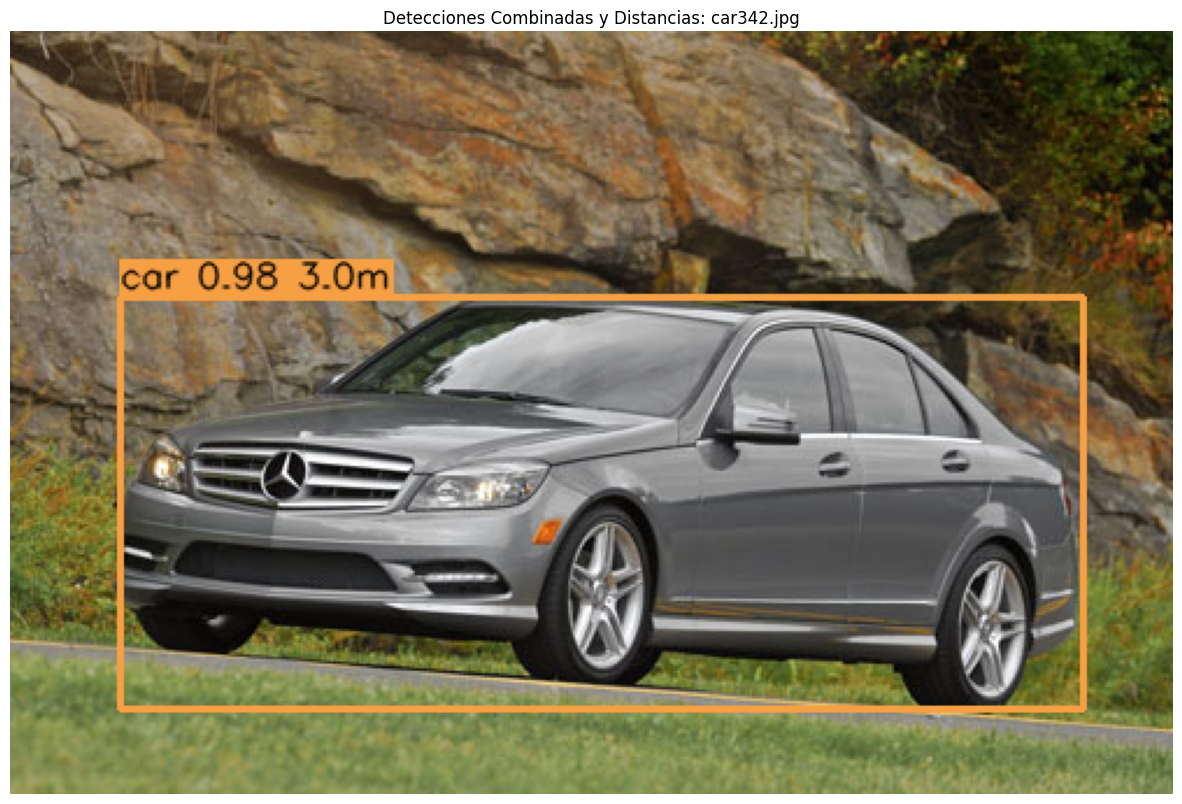


--- Fin de la Inferencia en Imagen con Dos Modelos ---


In [ ]:
# PASO 7: INFERENCIA EN IMAGEN CON DOS MODELOS Y ESTIMACIÓN DE DISTANCIA (EN COLAB)
# Modelo 1: Tu 'best.pt' fine-tuned para vehículos.
# Modelo 2: 'yolov8n.pt' pre-entrenado en COCO para personas, bicicletas, perros, etc.
# ==============================================================================
print("\nPaso 7: Inferencia en imagen con DOS modelos y estimación de distancia...")

# Dependencias (ya deberían estar importadas)
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from ultralytics import YOLO
# from google.colab import files # Para subir imagen de prueba

# --- Verificación y Carga de TU Modelo Fine-Tuned para Vehículos ---
if 'BEST_MODEL_PATH' not in locals() or not BEST_MODEL_PATH or not os.path.exists(BEST_MODEL_PATH):
    print("ADVERTENCIA: BEST_MODEL_PATH (tu modelo de vehículos) no está definido o el archivo no existe.")
    # ... (lógica de fallback para BEST_MODEL_PATH, si la tienes) ...
    # Por simplicidad, asumiremos que BEST_MODEL_PATH ya está correctamente definido.
    if not ('BEST_MODEL_PATH' in locals() and BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH)):
        print("ERROR CRÍTICO: No se pudo encontrar tu modelo fine-tuned. Deteniendo.")
        # Puedes detener la ejecución aquí si lo prefieres: raise FileNotFoundError("Modelo fine-tuned no encontrado")
        # Por ahora, solo imprimirá el error y el script podría fallar más adelante.

if 'BEST_MODEL_PATH' in locals() and BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    print(f"Cargando tu modelo fine-tuned para VEHÍCULOS desde: {BEST_MODEL_PATH}")
    model_vehicles = YOLO(BEST_MODEL_PATH)
    print(f"Clases conocidas por tu modelo de vehículos: {model_vehicles.names}")

    # --- Carga del Modelo COCO Pre-entrenado ---
    print("\nCargando modelo YOLOv8n.pt pre-entrenado en COCO...")
    model_coco = YOLO('yolov8n.pt') # Carga el modelo estándar de COCO
    print(f"Modelo COCO cargado. Puede detectar ~80 clases, incluyendo 'person', 'bicycle', 'dog'.")
    # Descomenta la siguiente línea si quieres ver todas las clases de COCO:
    # print(f"Clases del modelo COCO: {model_coco.names}")


    # --- Configuración de la Imagen de Prueba ---
    IMAGE_TO_TEST_PATH_MULTI = None
    if 'VALID_DIR' in locals() and os.path.exists(os.path.join(VALID_DIR, 'images')):
        valid_images_multi = glob.glob(os.path.join(VALID_DIR, 'images', '*.jpg')) + \
                             glob.glob(os.path.join(VALID_DIR, 'images', '*.png'))
        if valid_images_multi:
            IMAGE_TO_TEST_PATH_MULTI = valid_images_multi[0]
            print(f"\nUsando imagen de validación para prueba: {IMAGE_TO_TEST_PATH_MULTI}")

    if not IMAGE_TO_TEST_PATH_MULTI:
        print("\nNo se encontró imagen de validación. Por favor, sube una imagen para la prueba:")
        uploaded_image_multi = files.upload()
        if uploaded_image_multi:
            IMAGE_TO_TEST_PATH_MULTI = list(uploaded_image_multi.keys())[0]
            print(f"Usando imagen subida: {IMAGE_TO_TEST_PATH_MULTI}")
        else:
            print("No se subió ninguna imagen.")

    if IMAGE_TO_TEST_PATH_MULTI and os.path.exists(IMAGE_TO_TEST_PATH_MULTI):
        print(f"Procesando imagen con ambos modelos: {IMAGE_TO_TEST_PATH_MULTI}")

        # --- Parámetros para Estimación de Distancia y Detección ---
        FOCAL_LENGTH_PX_MULTI = 700  # <<<<<<< AJUSTA ESTO PARA TU CÁMARA!
        # Tamaños reales para TODAS las clases que esperas detectar y estimar distancia
        REAL_OBJECT_SIZES_M_MULTI = {
            # De tu modelo de vehículos
            'car': 1.8, 'threewheel': 1.2, 'bus': 2.5, 'truck': 2.6, 'motorbike': 0.8, 'van': 2.0,
            # De COCO (asegúrate que los nombres coincidan con model_coco.names si es necesario)
            'person': 0.5, 'bicycle': 0.4, 'dog': 0.3
            # 'pothole' no está en COCO, necesitarías tu propio modelo para eso.
        } # <<<<<<< AJUSTA ESTOS VALORES!
        CONFIDENCE_THRESHOLD_MULTI = 0.35 # <<<<< AJUSTA UMBRAL GENERAL

        try:
            # Cargar la imagen una vez
            original_image = cv2.imread(IMAGE_TO_TEST_PATH_MULTI)
            if original_image is None:
                raise FileNotFoundError(f"No se pudo leer la imagen: {IMAGE_TO_TEST_PATH_MULTI}")

            annotated_image_multi = original_image.copy() # Para dibujar

            all_detections_for_drawing = [] # Lista para almacenar todas las detecciones

            # --- Inferencia con tu Modelo de Vehículos ---
            print("\nProcesando con tu modelo de VEHÍCULOS...")
            results_vehicles = model_vehicles(original_image, conf=CONFIDENCE_THRESHOLD_MULTI)
            if results_vehicles:
                res_v = results_vehicles[0]
                print(f"  Modelo de vehículos detectó {len(res_v.boxes)} objetos.")
                for i in range(len(res_v.boxes)):
                    box_data = res_v.boxes[i]
                    all_detections_for_drawing.append({
                        "xywh": box_data.xywh.cpu().numpy()[0],
                        "cls_id": int(box_data.cls.cpu().item()),
                        "conf": float(box_data.conf.cpu().item()),
                        "model_names": model_vehicles.names # Nombres de este modelo
                    })

              # --- Inferencia con Modelo COCO ---
            # Solo procesar para clases de COCO que te interesan y NO son tus vehículos principales
            coco_classes_to_detect_ids = [] # Lista para almacenar los IDs de clase de COCO
            coco_classes_names_to_seek = ['person', 'bicycle', 'dog']

            print(f"\nBuscando IDs para clases de COCO deseadas: {coco_classes_names_to_seek}")
            if isinstance(model_coco.names, dict): # Verificar si es un diccionario
                for name_to_seek in coco_classes_names_to_seek:
                    found_id = None
                    for class_id, class_name in model_coco.names.items(): # Iterar sobre el diccionario
                        if class_name == name_to_seek:
                            found_id = class_id
                            break # Encontrado, salir del bucle interno
                    if found_id is not None:
                        coco_classes_to_detect_ids.append(found_id)
                        print(f"  Clase COCO '{name_to_seek}' encontrada con ID: {found_id}")
                    else:
                        print(f"  ADVERTENCIA: La clase COCO '{name_to_seek}' no se encontró en model_coco.names.")
            else:
                # Fallback si model_coco.names fuera una lista (menos probable con versiones recientes)
                print("ADVERTENCIA: model_coco.names no es un diccionario, intentando como lista (esto es inusual).")
                for name_to_seek in coco_classes_names_to_seek:
                    try:
                        idx = model_coco.names.index(name_to_seek)
                        coco_classes_to_detect_ids.append(idx)
                        print(f"  Clase COCO '{name_to_seek}' (tratada como lista) encontrada con ID: {idx}")
                    except ValueError:
                        print(f"  ADVERTENCIA: La clase COCO '{name_to_seek}' no se encontró en model_coco.names (tratada como lista).")


            print(f"\nProcesando con modelo COCO (buscando IDs: {coco_classes_to_detect_ids})...")
            if coco_classes_to_detect_ids: # Solo predecir si tenemos clases objetivo
                 # Asegurarse que la lista de clases no esté vacía si algunas no se encontraron
                 if not coco_classes_to_detect_ids:
                     print("  No se encontraron IDs válidos para las clases de COCO deseadas. Omitiendo predicción de COCO.")
                 else:
                    results_coco = model_coco(original_image, conf=CONFIDENCE_THRESHOLD_MULTI, classes=coco_classes_to_detect_ids)
                    if results_coco:
                        res_c = results_coco[0]
                        print(f"  Modelo COCO detectó {len(res_c.boxes)} objetos de las clases seleccionadas.")
                        for i in range(len(res_c.boxes)):
                            box_data = res_c.boxes[i]
                            all_detections_for_drawing.append({
                                "xywh": box_data.xywh.cpu().numpy()[0],
                                "cls_id": int(box_data.cls.cpu().item()), # Este cls_id es el ID real del modelo COCO
                                "conf": float(box_data.conf.cpu().item()),
                                "model_names": model_coco.names # Diccionario de nombres del modelo COCO
                            })
            else: # Esto se daría si la lista coco_classes_names_to_seek estuviera vacía inicialmente
                print("  No se especificaron clases de COCO para buscar, omitiendo predicción de COCO.")

            # --- Dibujar TODAS las detecciones acumuladas ---
            # Aquí podrías implementar Non-Maximum Suppression (NMS) entre los resultados de ambos modelos
            # si hubiera riesgo de solapamiento significativo (ej. ambos detectando 'car').
            # Por ahora, simplemente las dibujaremos todas.

            print(f"\nDibujando {len(all_detections_for_drawing)} detecciones totales...")
            for det in all_detections_for_drawing:
                x_c, y_c, w, h = det["xywh"]
                cls_id = det["cls_id"]
                conf_val = det["conf"]
                current_model_names = det["model_names"] # Nombres del modelo que hizo esta detección

                label_name = current_model_names[cls_id] # Obtener el nombre correcto

                x1, y1 = int(x_c - w/2), int(y_c - h/2)
                x2, y2 = int(x_c + w/2), int(y_c + h/2)

                # Color (necesitamos un mapa de color más grande o una forma de manejarlo)
                # Usaremos un color diferente si es de COCO o de vehículos para distinguirlos
                is_vehicle_class = label_name in model_vehicles.names

                # Generar un color pseudo-aleatorio basado en el ID de clase y el nombre del modelo
                # Esto es para ayudar a distinguir, pero no es un mapeo de color fijo.
                # Para un mapeo fijo, necesitarías una lista global de todas las clases posibles y sus colores.
                temp_hash = hash(label_name + str(is_vehicle_class)) # Hash para generar colores
                box_clr = [(temp_hash & 0xFF), ((temp_hash >> 8) & 0xFF), ((temp_hash >> 16) & 0xFF)]


                cv2.rectangle(annotated_image_multi, (x1, y1), (x2, y2), box_clr, 2)

                dist_m = -1
                if label_name in REAL_OBJECT_SIZES_M_MULTI and REAL_OBJECT_SIZES_M_MULTI[label_name] > 0:
                    w_real_m_val = REAL_OBJECT_SIZES_M_MULTI[label_name]
                    if w > 0: dist_m = (w_real_m_val * FOCAL_LENGTH_PX_MULTI) / w

                txt_lbl = f"{label_name} {conf_val:.2f}"
                if dist_m > 0: txt_lbl += f" {dist_m:.1f}m"

                (txt_w, txt_h), baseline = cv2.getTextSize(txt_lbl, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(annotated_image_multi, (x1, y1 - txt_h - 4), (x1 + txt_w, y1-2), box_clr, -1)
                cv2.putText(annotated_image_multi, txt_lbl, (x1, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)

            plt.figure(figsize=(15, 15)) # Más grande para ver detalles
            plt.imshow(cv2.cvtColor(annotated_image_multi, cv2.COLOR_BGR2RGB))
            plt.title(f"Detecciones Combinadas y Distancias: {os.path.basename(IMAGE_TO_TEST_PATH_MULTI)}")
            plt.axis('off')
            plt.show()

        except Exception as e_img_multi_proc:
            print(f"Error durante el procesamiento de la imagen con múltiples modelos: {e_img_multi_proc}")
            import traceback
            traceback.print_exc()
    else:
        print("No se especificó una imagen válida para la prueba.")
else:
    print("ERROR CRÍTICO: Tu modelo fine-tuned (BEST_MODEL_PATH) no es válido o no fue encontrado.")

print("\n--- Fin de la Inferencia en Imagen con Dos Modelos ---")